# 2016-09-30: Logistic Regression & Project

## 1. Logistic Regression 
In this lab, we will appply logistic regression to the Endometrium vs. Uterus cancer data

In [72]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [73]:
# Load the data
X = np.loadtxt('data/small_Endometrium_Uterus.csv',  delimiter=',', skiprows=1, usecols=range(1, 3001))

# Python 2.7 only
y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', skiprows=1, usecols=[3001], 
               converters={3001: lambda s: 0 if s=='Endometrium' else 1}, dtype='int')

# Python 3 alternative:
#y = np.loadtxt('data/small_Endometrium_Uterus.csv', delimiter=',', 
#               skiprows=1, usecols=[3001], dtype='bytes').astype('str')
# Convert 'Endometrium' to 0 and 'Uterus' to 1
#y = np.where(y=='Endometrium', 0, 1)

In [74]:
# Set up a stratified 10-fold cross-validation
from sklearn import cross_validation
folds = cross_validation.StratifiedKFold(y, 10, shuffle=True)
print folds

sklearn.cross_validation.StratifiedKFold(labels=[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1], n_folds=10, shuffle=True, random_state=None)


### 1.1 Cross-validation
**Question:** Create a cross-validation function that takes a design matrix, label array, scikit-learn classifier, and scikit-learn cross_validation object and returns the corresponding list of cross-validated predictions. 

Make sure that you are returning the predictions in the correct order!

Check the documentation of fit(X, y) and predict_proba(X) in sklearn.linear_model.LogisticRegression http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 

In [75]:
def cross_validate(design_matrix, labels, classifier, cv_folds):
    pred = np.zeros(labels.shape)
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape
        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte) # two-dimensional array
        # Identify the index, in yte_pred, of the positive class (y=1)
        # index_of_class_1 = np.nonzero(classifier.classes_ == 1)[0][0] 
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1] 
    return pred

Now use this function to compute cross-validated predictions on the data.

In [76]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1e6) # high C means no regularization (we'll talk about regularization next week!)
ypred_logreg = cross_validate(X, y, clf, folds)
ypred_logreg_around = np.around(ypred_logreg)
ypred_logreg_around_int = ypred_logreg_around.astype(numpy.int64)

**Question** Complete the code below to compute the cross-validated accuracy and area under the curve of the logistic regression on our data. Plot the ROC curve

Accuracy: 0.650273


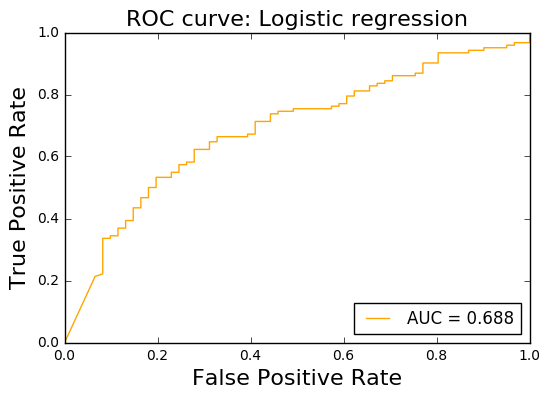

In [77]:
from sklearn import metrics

fpr_logreg, tpr_logreg, thresholds = metrics.roc_curve(y, ypred_logreg, pos_label=1)
accuracy = metrics.accuracy_score(y,ypred_logreg_around_int)
print "Accuracy: %f" % (accuracy)
auc_logreg = metrics.auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, '-', color='orange', label='AUC = %0.3f' % auc_logreg
)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")
#plt.savefig('%s/evu_linreg.pdf' % fig_dir, bbox_inches='tight')

### 1.2 Feature scaling

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance). If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.

Scikit-learn offers tools to deal with this issue. 

In [78]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)

Let us now visualize the distribution of one of the features of the data.

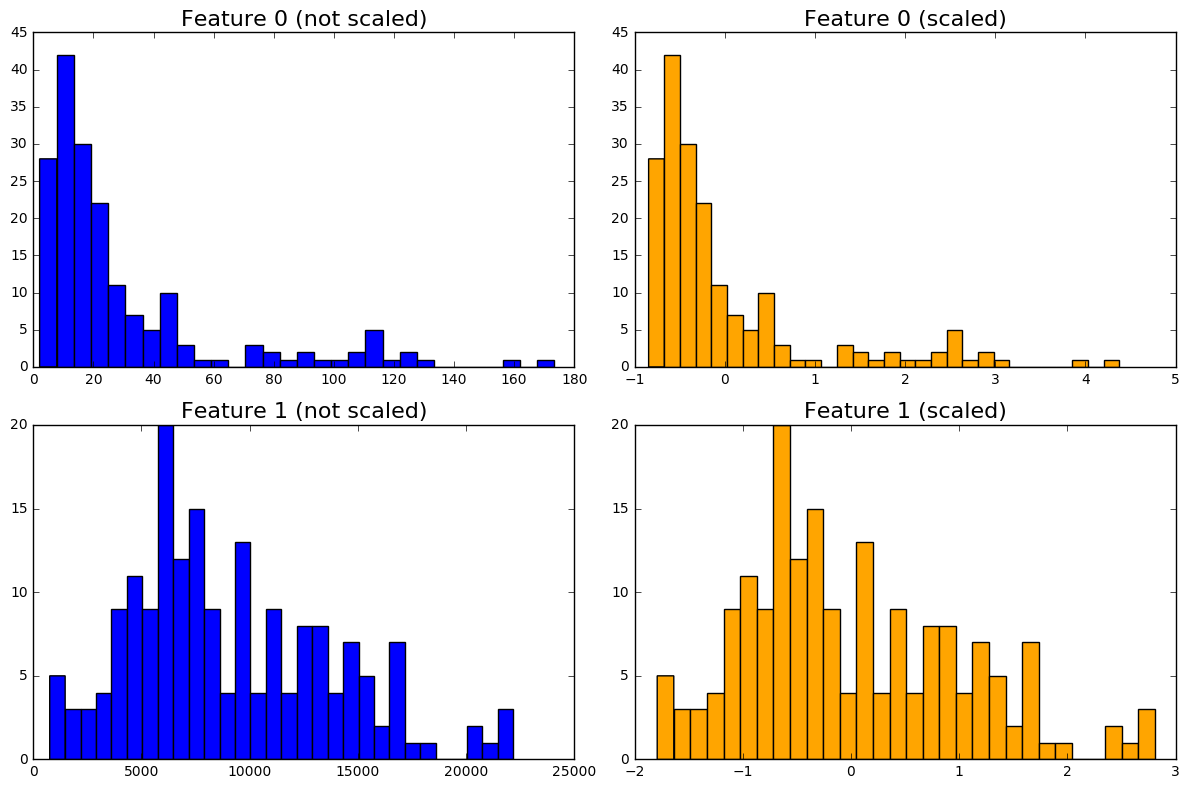

In [79]:
idx_1 = 0 # first feature
fig = plt.figure(figsize=(12, 8)) # (width, height)

fig.add_subplot(221) # 2 x 2 grid, 1st subplot
h = plt.hist(X[:, idx_1], bins=30, color='blue')
plt.title('Feature %d (not scaled)' % idx_1, fontsize=16)

fig.add_subplot(222) # 2 x 2 grid, 2nd subplot
h = plt.hist(X_scaled[:, idx_1], bins=30, color='orange')
plt.title('Feature %d (scaled)' % idx_1, fontsize=16)

idx_2 = 1 # second feature

fig.add_subplot(223) # 2 x 2 grid, 3rd subplot
h = plt.hist(X[:, idx_2], bins=30, color='blue')
plt.title('Feature %d (not scaled)' % idx_2, fontsize=16)

fig.add_subplot(224) # 2 x 2 grid, 4th subplot
h = plt.hist(X_scaled[:, idx_2], bins=30, color='orange')
plt.title('Feature %d (scaled)' % idx_2, fontsize=16)

plt.tight_layout() # improve spacing between subplots

**Question** Compute the cross-validated predictions of the logistic regression on the scaled data.

In [80]:
from sklearn import linear_model
clf2 = linear_model.LogisticRegression(C=1e6) # high C means no regularization (we'll talk about regularization next week!)
ypred_logreg2 = cross_validate(X_scaled, y, clf2, folds)

**Question** Plot the two ROC curves (one for the logistic regression on the original data, one for the logistic regression on the scaled data) on the same plot.

Accuracy: 0.502732


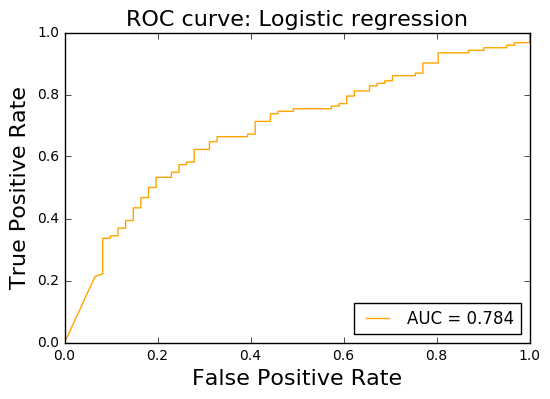

In [81]:
from sklearn import metrics
ypred_logreg_around2 = np.around(ypred_logreg2)
ypred_logreg_around_int2 = ypred_logreg_around2.astype(numpy.int64)
accuracy2 = metrics.accuracy_score(y,ypred_logreg_around_int2)
print "Accuracy: %f" % (accuracy2)
fpr_logreg2, tpr_logreg2, thresholds2 = metrics.roc_curve(y, ypred_logreg2, pos_label=1)

auc_logreg2 = metrics.auc(fpr_logreg2, tpr_logreg2)
plt.plot(fpr_logreg, tpr_logreg, '-', color='orange', label='AUC = %0.3f' % auc_logreg2
)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")


#plt.savefig('%s/evu_linreg.pdf' % fig_dir, bbox_inches='tight')

### 1.3 Feature scaling and cross-validation
In a cross-validation setting, we ignore the samples from the test fold when training the classifier. This also means that scaling should be done on the training data only. 

In scikit-learn, we can use a scaler to make centering and scaling happen independently on each feature by computing the relevant statistics on the samples *in the training set*. 
The mean and standard deviation will be stored to be used on the test data.

In [82]:
scaler = preprocessing.StandardScaler()
#Xtr = scaler.fit_transform(Xtr)
#Xte = scaler.transform(Xte)

**Question** Rewrite the cross_validate method to include a scaling step.

In [83]:
def cross_validate_with_scaling(design_matrix, labels, classifier, cv_folds):
    pred = np.zeros(labels.shape) # vector of 0 in which to store the predictions
    for tr, te in cv_folds:
        # Restrict data to train/test folds
        Xtr = design_matrix[tr, :]
        ytr = labels[tr]
        Xte = design_matrix[te, :]
        #print Xtr.shape, ytr.shape, Xte.shape

        # Scale data
        scaler = preprocessing.StandardScaler() # create scaler
        Xtr = scaler.fit_transform(Xtr) # fit the scaler to the training data and transform training data
        Xte = scaler.transform(Xte) # transform test data

        # Fit classifier
        classifier.fit(Xtr, ytr)

        # Predict probabilities (of belonging to +1 class) on test data
        yte_pred = classifier.predict_proba(Xte) # two-dimensional array
        # Identify the index, in yte_pred, of the positive class (y=1)
        # index_of_class_1 = np.nonzero(classifier.classes_ == 1)[0][0] 
        index_of_class_1 = 1 - ytr[0] # 0 if the first sample is positive, 1 otherwise
        pred[te] = yte_pred[:, index_of_class_1]                
    return pred

**Question** Now use the cross_validate_with_scaling method to cross-validate the logistic regression on our data.

In [84]:
from sklearn import linear_model
clf3 = linear_model.LogisticRegression(C=1e6) # high C means no regularization (we'll talk about regularization next week!)
ypred_logreg3 = cross_validate_with_scaling(X, y, clf, folds)

**Question** Again, compare the AUROC and ROC curves with those obtained previously. What do you conclude?

Accuracy: 0.797814


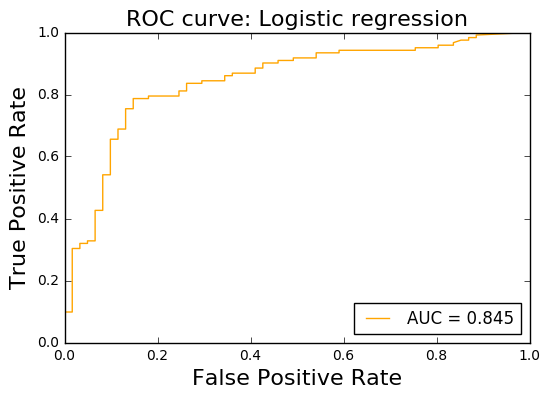

In [85]:
from sklearn import metrics
ypred_logreg_around3 = np.around(ypred_logreg3)
ypred_logreg_around_int3 = ypred_logreg_around3.astype(numpy.int64)
accuracy3 = metrics.accuracy_score(y,ypred_logreg_around_int3)
print "Accuracy: %f" % (accuracy3)
fpr_logreg3, tpr_logreg3, thresholds3 = metrics.roc_curve(y, ypred_logreg3, pos_label=1) 
auc_logreg3 = metrics.auc(fpr_logreg3, tpr_logreg3)
plt.plot(fpr_logreg3, tpr_logreg3, '-', color='orange', label='AUC = %0.3f' % auc_logreg3
)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")
#plt.savefig('%s/evu_linreg.pdf' % fig_dir, bbox_inches='tight')

### 1.4 Sample normalization
Normalization is the process of scaling individual samples to have unit norm. It can be useful when using machine learning algorithms that use the distance between samples.

In [86]:
X_norm = preprocessing.normalize(X)

**Question** Repeat the previous analysis using the normalized data (and the same cross-validation folds), i.e. compare the cross-validated logistic regression on 
* the origal data
* the normalized data
* the normalized then scaled data
* the normalized data, in a cross-validation with scaling procedure.
What do you observe?

Accuracy: 0.797814
Accuracy:


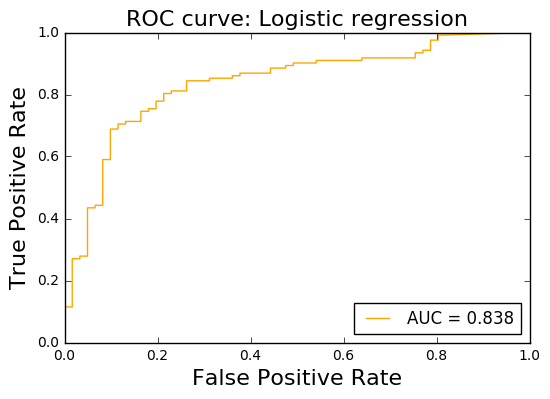

In [87]:
#just do the last one
from sklearn import linear_model
clf4 = linear_model.LogisticRegression(C=1e6) # high C means no regularization (we'll talk about regularization next week!)
ypred_logreg4 = cross_validate_with_scaling(X_norm, y, clf4, folds)

from sklearn import metrics
ypred_logreg_around4 = np.around(ypred_logreg4)
ypred_logreg_around_int4 = ypred_logreg_around4.astype(numpy.int64)
accuracy4 = metrics.accuracy_score(y,ypred_logreg_around_int4)
print "Accuracy: %f" % (accuracy4)
fpr_logreg4, tpr_logreg4, thresholds4 = metrics.roc_curve(y, ypred_logreg4, pos_label=1) 
auc_logreg4 = metrics.auc(fpr_logreg4, tpr_logreg4)
plt.plot(fpr_logreg4, tpr_logreg4, '-', color='orange', label='AUC = %0.3f' % auc_logreg4
)

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve: Logistic regression', fontsize=16)
plt.legend(loc="lower right")
#plt.savefig('%s/evu_linreg.pdf' % fig_dir, bbox_inches='tight')

## 2. Kaggle Project

* Load the data
* How many features do you have? How are they encoded?
* Plot histograms to visualize the distribution of your features. Should you scale or normalize them?
* Set up a cross-validation that you will use for all your evaluations. Notice there is a 'random_state' parameter to the cross-validation methods of scikit-learn, that you can use to ensure you always get the same splits. 
* [Optional] To go one step further in ensuring a fair comparison of your algorithms, you can use multiple repeats of the cross-validation procedure (using different splits each time), and report the mean & standard deviation over the repeats of the performance obtained. If you do this, you can report standard deviations in plots by using error bars.
* Evaluate the performance of a linear regression on your data. Which evaluation metric are you using? See http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for help defining one.
* Submit a linear regression predictor to the leaderboard.